In [53]:
import pandas as pd
import seaborn as sns
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from typing import *
import math
import json
from utils import dref_dataframe

sns.set_style("whitegrid")
sns.set_context("poster", font_scale=0.75)
sns.set_palette("colorblind6")

def plot_core_configs(cores: list[int], do_plot: Callable[[int, any], plt.Axes]):
    ncores = len(cores)
    fig, axes = plt.subplots(ncores // 3 + (1 if ncores % 3 != 0 else 0), 3, figsize=(30,15))
    for i, c in enumerate(cores):
        col = i % 3
        f = do_plot(c, axes[i // 3, col])
        if col != 0:
            f.set_ylabel("")

In [54]:
def load_stream_csv(p: Path, cores: int, driver: str) -> pd.DataFrame:
    data = pd.read_csv(p / f"{driver}-stream" / str(cores) / "Copy.csv")
    times = data["IterTime"]
    t_sum = 0.0
    for i in range(0, len(times)):
        t_sum += times[i]
        times[i] = t_sum

    data["Bandwidth"] /= 1000.0
    return data.assign(Cores=cores, Driver=driver)

def load_streams(p: Path, cores: list[int], max_t: float = 120.0) -> pd.DataFrame:
    frames = []
    for c in cores:
        base = load_stream_csv(p, c, "virtio-balloon")
        retained_samples = next((i for i, t in enumerate(base["IterTime"]) if t >= max_t), len(base["IterTime"]))
        frames.append(base.head(retained_samples))
        for d in ["virtio-balloon-huge", "virtio-mem", "llfree"]:
            frames.append(load_stream_csv(p, c, d).head(retained_samples))

    return pd.concat(frames)

stream = load_streams(Path("stream/latest"), [1, 2, 4, 8, 10, 12])
dref_dataframe("stream", Path("stream"), ["Driver", "Cores", "IterTime"], stream)

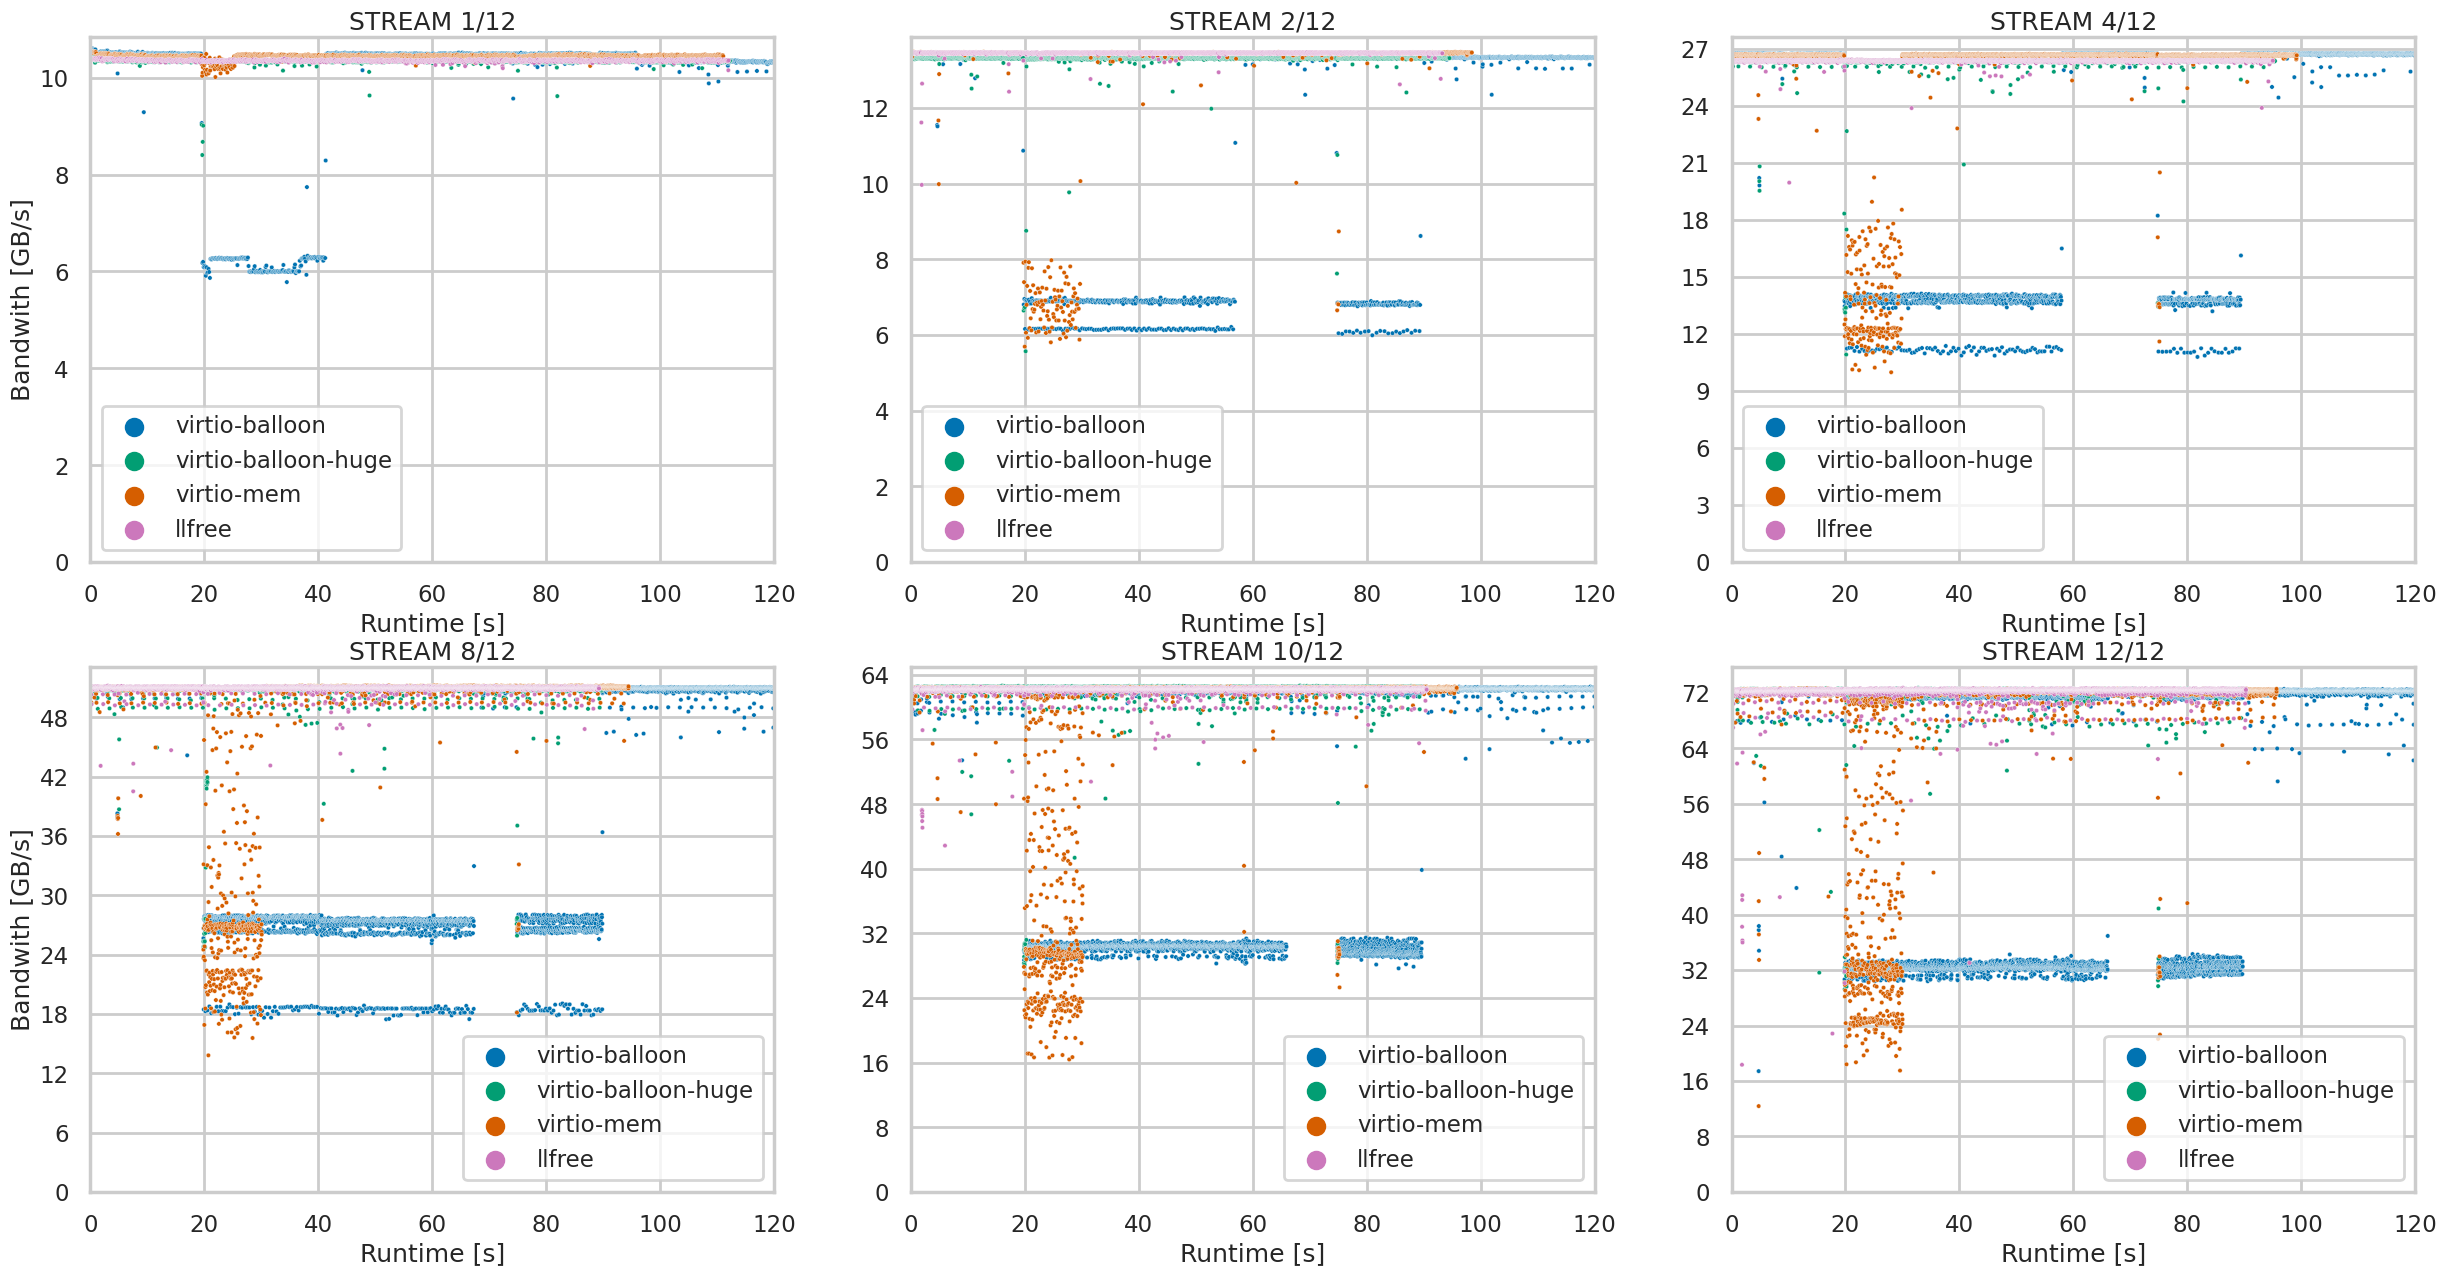

In [14]:
def plot_stream(cores: int, axis: any) -> plt.Axes:
    d = stream.loc[stream["Cores"] == cores]
    plot = sns.scatterplot(x="IterTime", y="Bandwidth", data=d, hue="Driver", s=10.0, ax=axis)
    plot.set_xlim(0.0, 120.0)
    plot.set_ylim(0.0)
    axis.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    plot.set_ylabel("Bandwith [GB/s]")
    plot.set_xlabel("Runtime [s]")
    plot.set_title(f"STREAM {cores}/12")
    #plot.get_legend().set_visible(False)
    plot.get_legend().set_title("")
    return plot

plot_core_configs([1, 2, 4, 8, 10, 12], plot_stream)

In [55]:
def calc_stream_speedz(cores: list[int]) -> pd.DataFrame:
    frames = []
    for c in cores:
        core_data = stream.loc[stream["Cores"] == c]
        virtio_balloon = core_data.loc[core_data["Driver"] == "virtio-balloon"]
        virtio_balloon_huge = core_data.loc[core_data["Driver"] == "virtio-balloon-huge"]
        virtio_mem = core_data.loc[core_data["Driver"] == "virtio-mem"]
        llfree = core_data.loc[core_data["Driver"] == "llfree"]
        long_time = virtio_balloon["IterTime"][len(virtio_balloon["IterTime"]) - 1]
        frames.append(pd.DataFrame({"Faster": [long_time-virtio_balloon_huge["IterTime"][len(long_time-virtio_balloon_huge["IterTime"]) - 1], 
                                        long_time-llfree["IterTime"][len(long_time-llfree["IterTime"])-1], 
                                        long_time-virtio_mem["IterTime"][len(long_time-virtio_mem["IterTime"]) -1]], 
                                        "Driver": ["balloon-huge", "llfree", "virtio-mem"]}).assign(Cores=c))
    return pd.concat(frames)


stream_speedz = calc_stream_speedz([1, 2, 4, 8, 10, 12])
dref_dataframe("stream-speed", Path("stream"), ["Cores", "Driver"], stream_speedz)

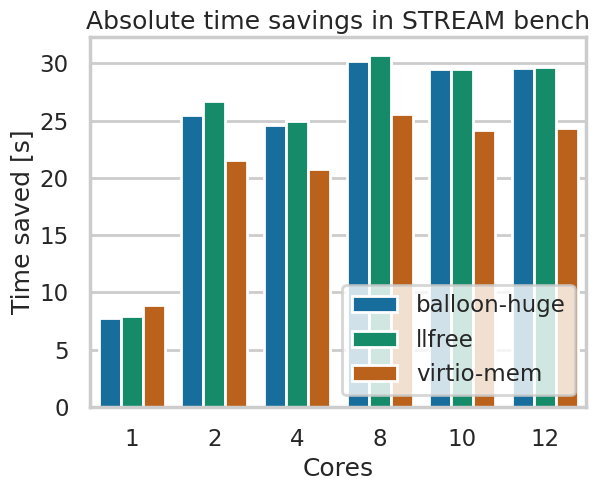

In [42]:
plot = sns.barplot(data=stream_speedz, x="Cores", y="Faster", hue="Driver")
plot.set_ylabel("Time saved [s]")
plot.set_xlabel("Cores")
plot.set_title(f"Absolute time savings in STREAM bench")
plot.get_legend().set_title("")
sns.move_legend(plot, "lower right")


In [56]:
def sum_ftqs_batched(path: Path, cores: int, driver: str, samples: int) -> pd.DataFrame:
    p = path / f"{driver}-ftq" / str(cores)
    out = pd.DataFrame()
    counts = list(map(lambda s: int(s), (p / "counts.dat").read_text().splitlines()))
    times = list(map(lambda s: int(s), (p / "times.dat").read_text().splitlines()))
    for i in range(0, cores):
        data = pd.DataFrame()
        # TODO: How to combine cycle counts?
        data["Times"] = times[(samples*i):(samples*(i+1))]
        data["Counts"] = counts[(samples*i):(samples*(i+1))]
        if i == 0:
            out = data
        else:
            out += data
    start_cycle = out["Times"][0]
    out["Times"] -= start_cycle
    return out.tail(-1).assign(Cores=cores, Driver=driver)

def load_ftqs(p: Path, cores: list[int]) -> pd.DataFrame:
    frames = []
    for c in cores:
        for d in ["virtio-balloon", "virtio-balloon-huge", "virtio-mem", "llfree"]:
            frames.append(sum_ftqs_batched(p, c, d, 1000))

    return pd.concat(frames)

ftq = load_ftqs(Path("stream/latest"), [1, 2, 4, 8, 10, 12])
dref_dataframe("ftq", Path("stream"), ["Driver", "Cores", "Times"], ftq)

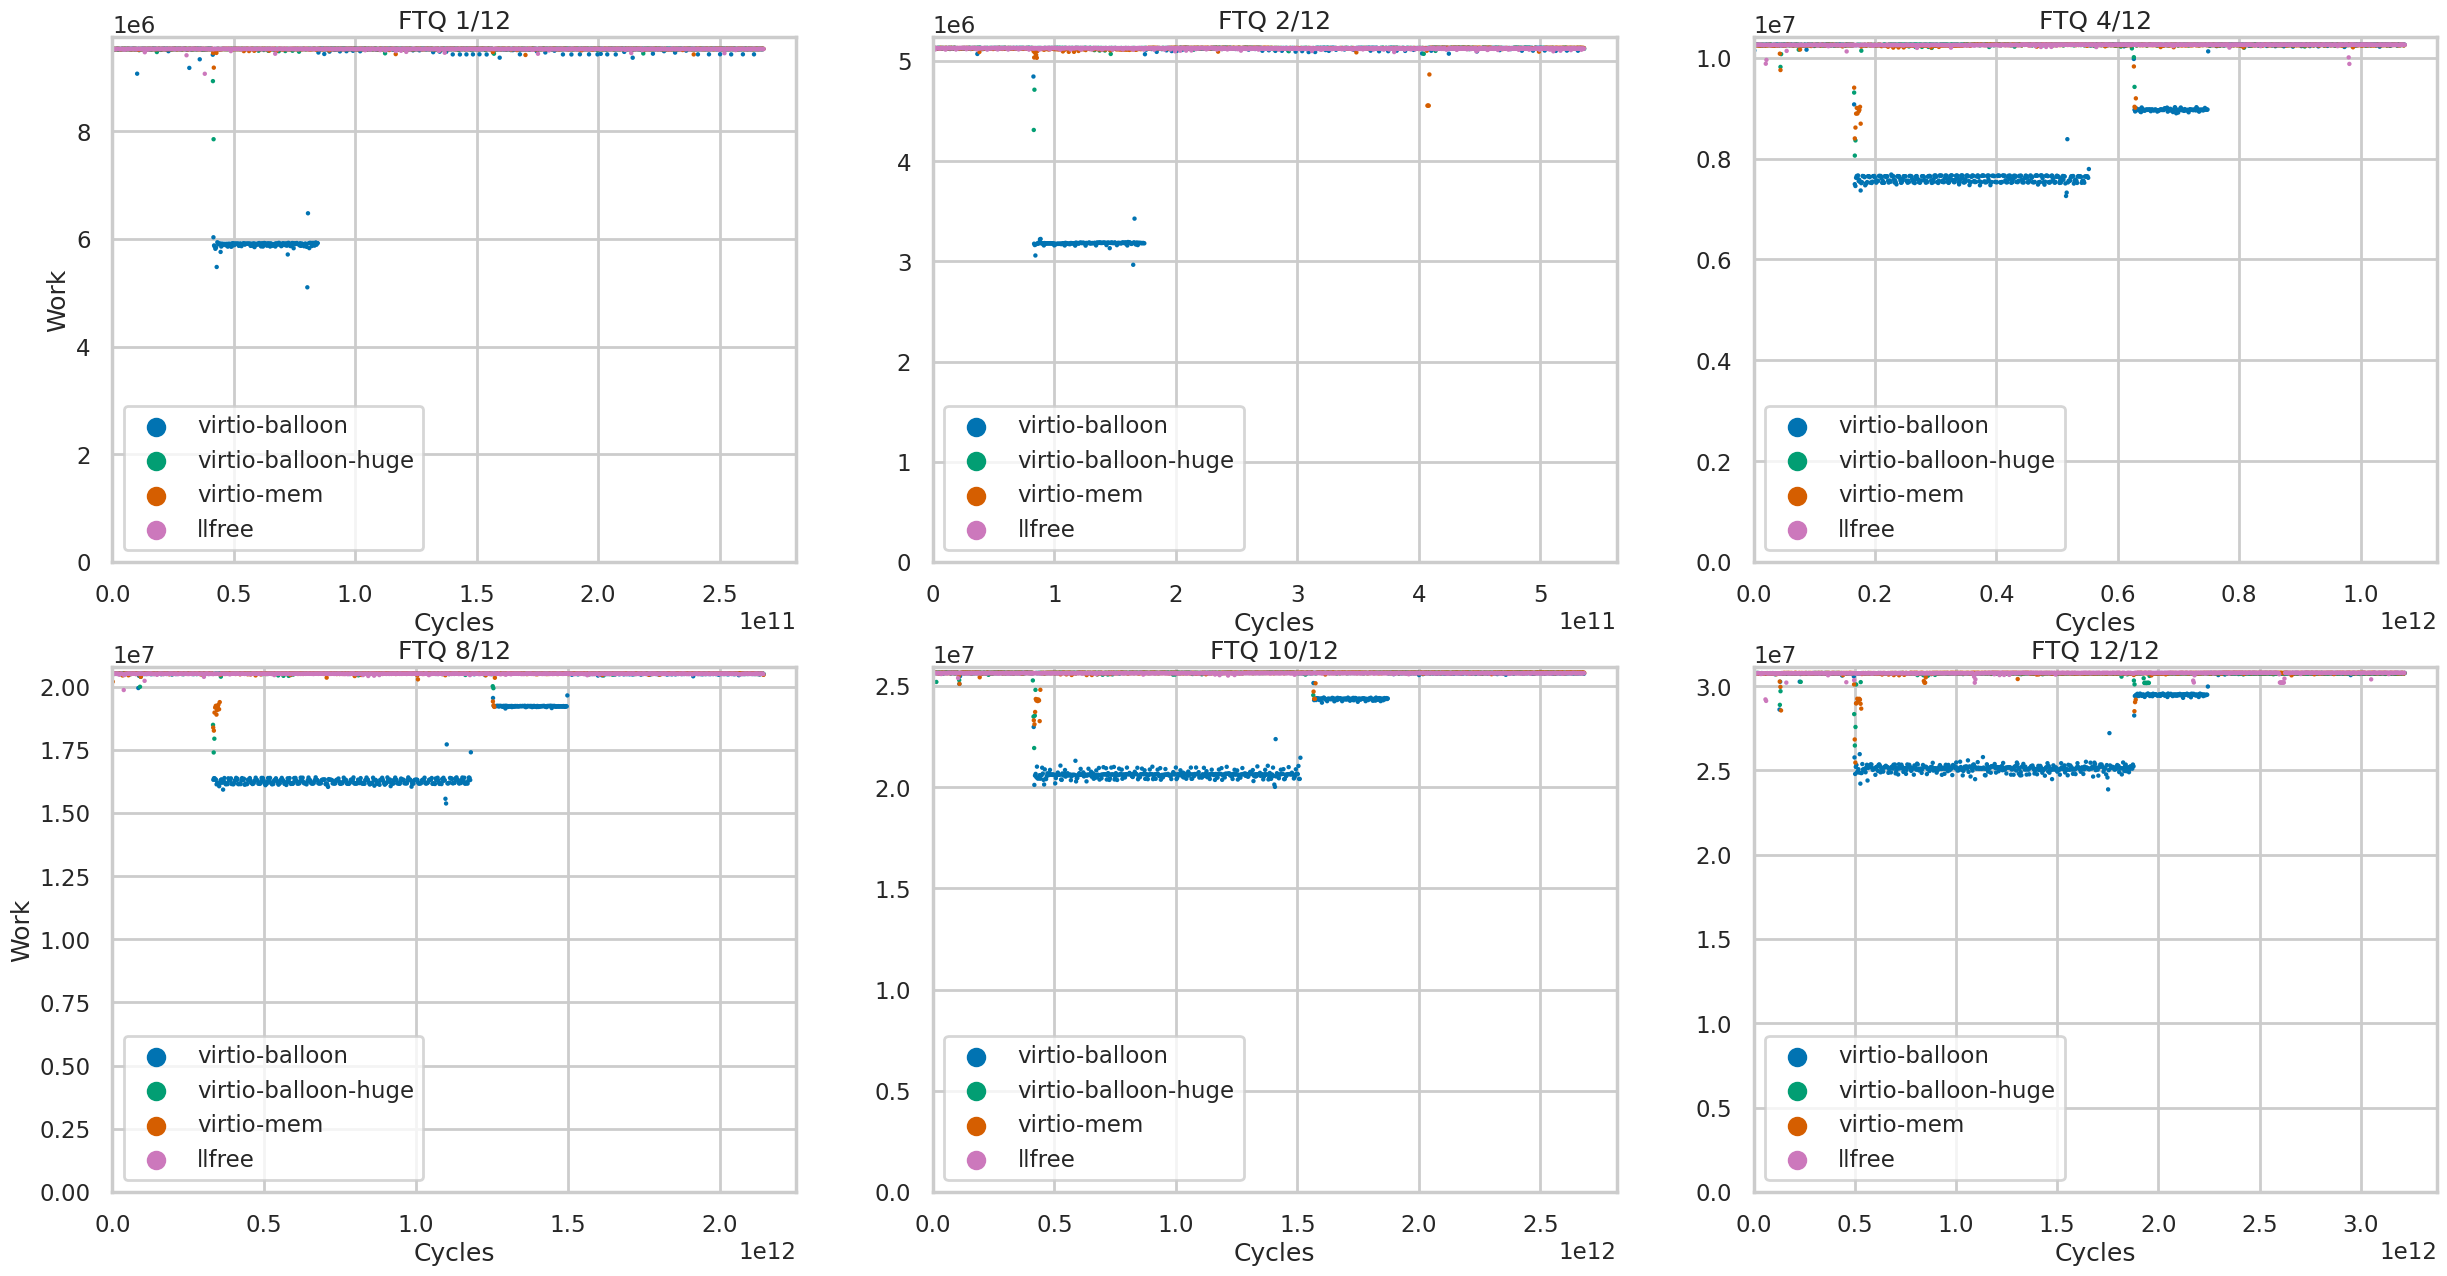

In [52]:
def plot_ftq2(cores: int, axis: any) -> plt.Axes:
    d = ftq.loc[ftq["Cores"] == cores]
    plot = sns.scatterplot(x="Times", y="Counts", data=d, hue="Driver", s=10.0, ax=axis, linewidth=0)
    plot.set_ylim(0.0)
    plot.set_xlim(0.0)
    plot.set_ylabel("Work")
    plot.set_xlabel("Cycles")
    plot.set_title(f"FTQ {cores}/12")
    #plot.get_legend().set_visible(False)
    plot.get_legend().set_title("")
    return plot

plot_core_configs([1, 2, 4, 8, 10, 12], plot_ftq2)

In [46]:
def calc_ftq_rel(cores: list[int]) -> pd.DataFrame:
    frames = []
    for c in cores:
        core_data = ftq.loc[ftq["Cores"] == c]
        virtio_balloon = core_data.loc[core_data["Driver"] == "virtio-balloon"].copy()
        virtio_balloon_huge = core_data.loc[core_data["Driver"] == "virtio-balloon-huge"].copy()
        virtio_mem = core_data.loc[core_data["Driver"] == "virtio-mem"].copy()
        llfree = core_data.loc[core_data["Driver"] == "llfree"].copy()
        virtio_balloon["Counts"] /= llfree["Counts"]
        virtio_balloon_huge["Counts"] /= llfree["Counts"]
        virtio_mem["Counts"] /= llfree["Counts"]
        frames.extend([virtio_balloon, virtio_balloon_huge, virtio_mem])
    return pd.concat(frames)

ftq_rel = calc_ftq_rel([1, 2, 4, 8, 10, 12])

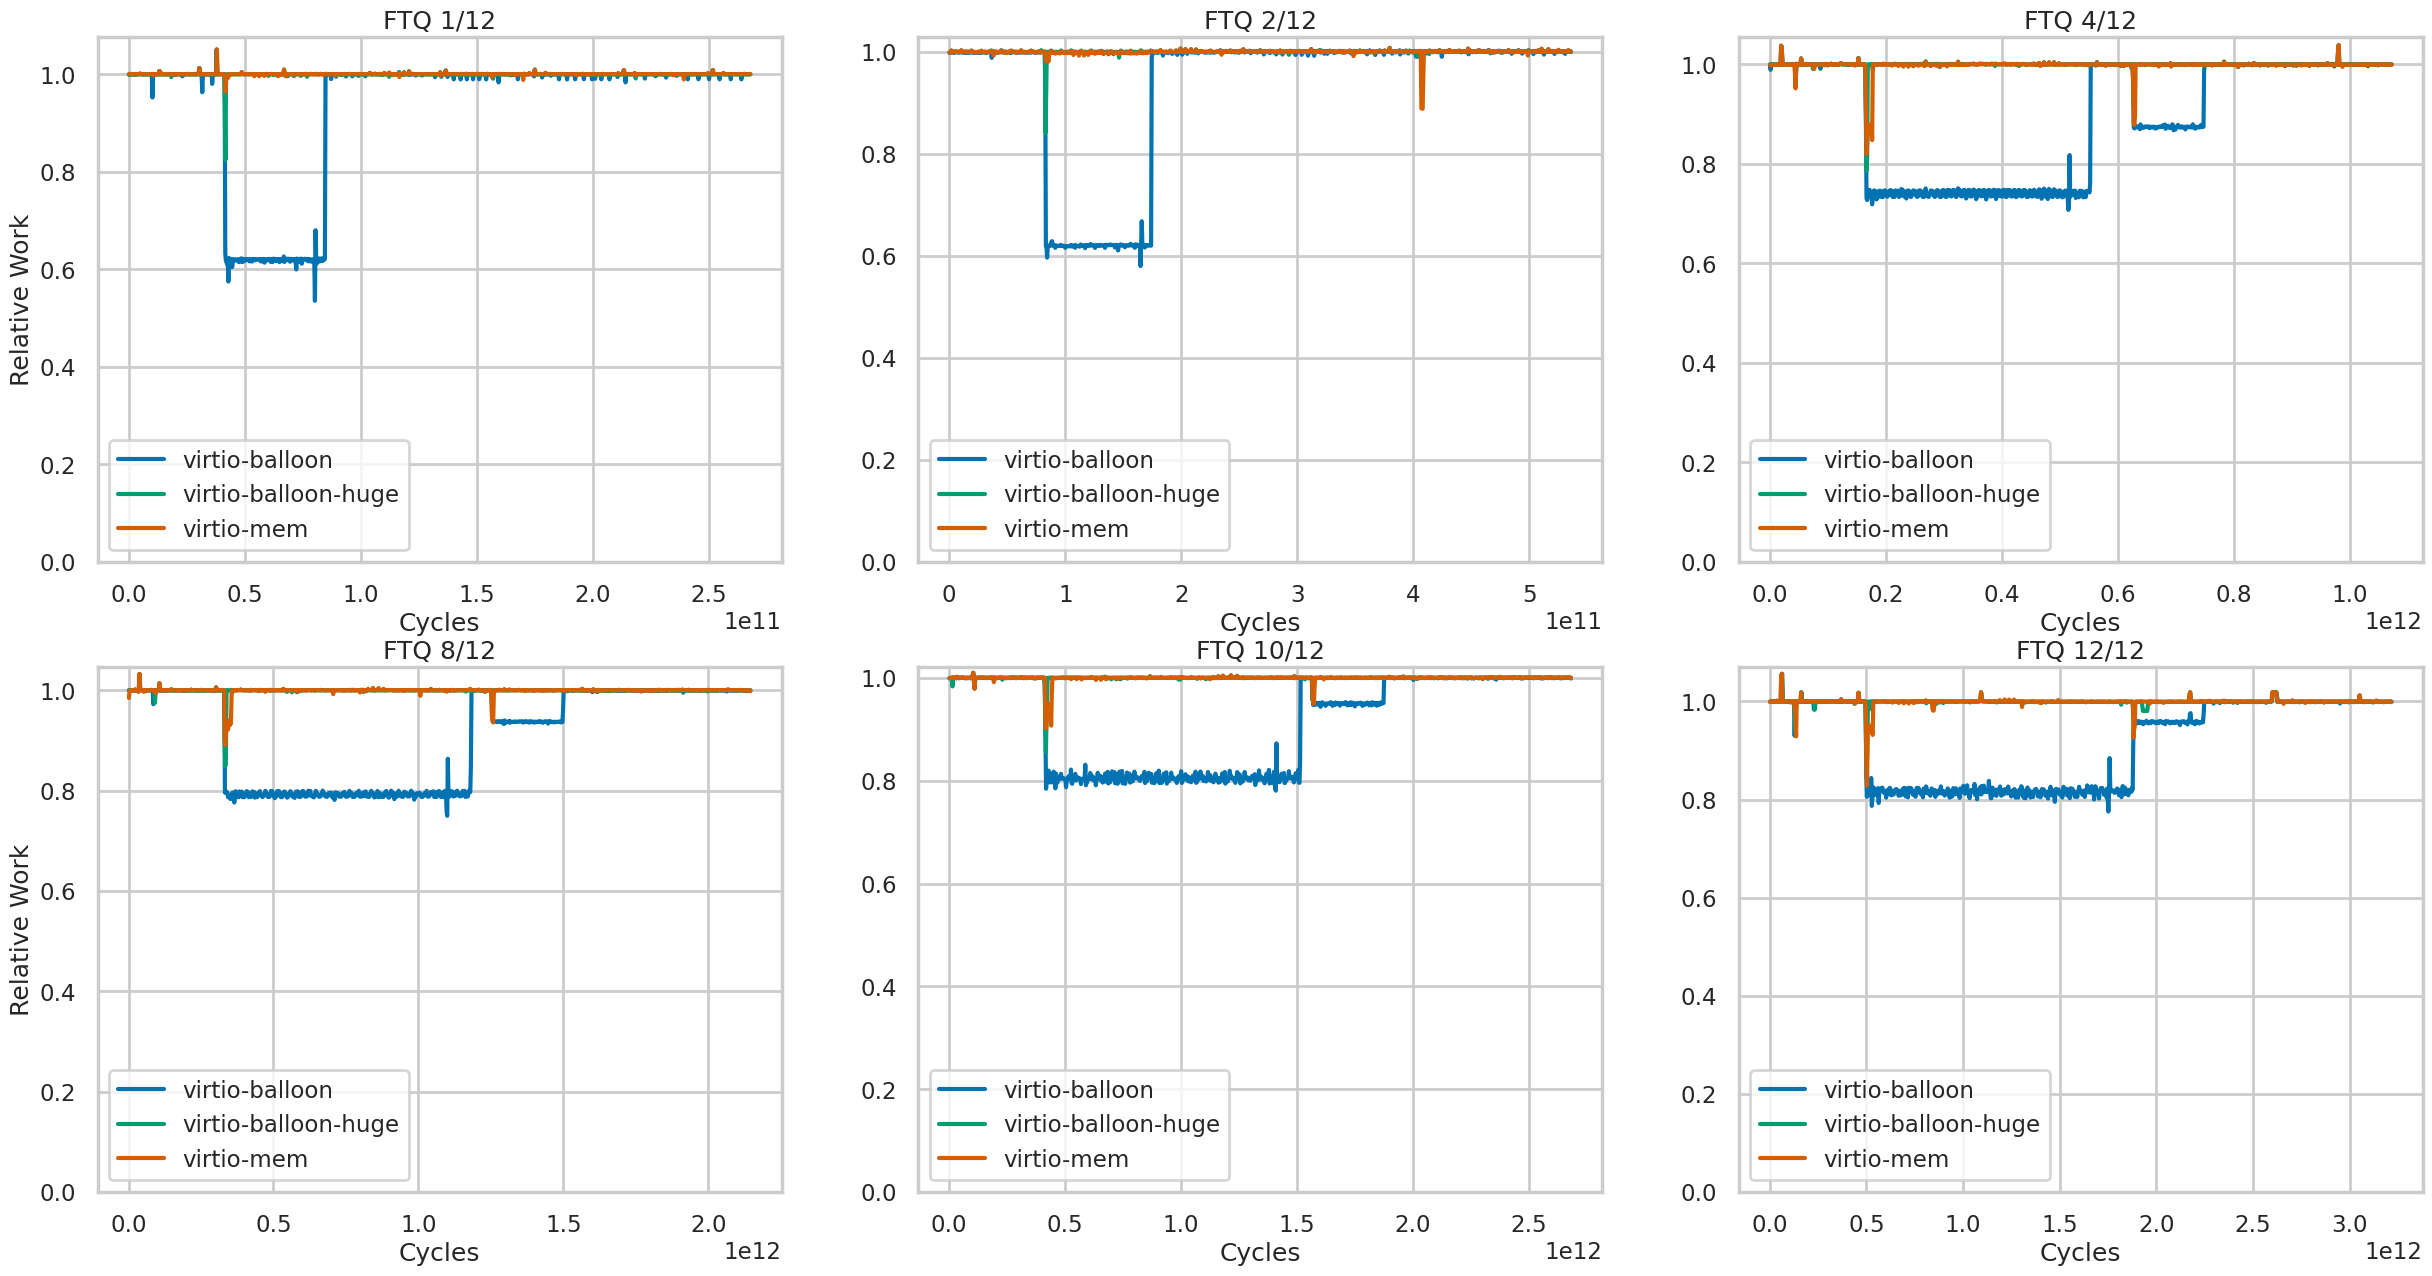

In [51]:
def plot_ftq_rel(cores: int, axis: any) -> plt.Axes:
    d = ftq_rel.loc[ftq_rel["Cores"] == cores]
    plot = sns.lineplot(x="Times", y="Counts", data=d, hue="Driver", ax=axis)
    #plot.set_ylim(0.0, 13.0)
    plot.set_ylim(0.0)
    #plot.set_xlim(0.0, 20)
    plot.set_ylabel("Relative Work")
    plot.set_xlabel("Cycles")
    plot.set_title(f"FTQ {cores}/12")
    #plot.get_legend().set_visible(False)
    plot.get_legend().set_title("")
    return plot

plot_core_configs([1, 2, 4, 8, 10, 12], plot_ftq_rel)